In [1]:
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import util
from __future__ import print_function
import setGPU
#os.environ['CUDA_VISIBLE_DEVICES']="6,7"

Welcome to JupyROOT 6.10/08
setGPU: Setting GPU to: 4


In [2]:
save_path = '/nfshome/emoreno/IN/'
#test_0 = np.load(save_path + 'test_features_0.npy')
#test_0 = np.swapaxes(test_0, 1, 2)
#test_1 = np.load(save_path + 'test_features_1.npy')
#test_1 = np.swapaxes(test_1, 1, 2)
test_2 = np.load(save_path + 'test_features_2.npy')
test_2 = np.swapaxes(test_2, 1, 2)
test_3 = np.load(save_path + 'test_features_3.npy')
test_3 = np.swapaxes(test_3, 1, 2)
target_test = np.load(save_path + 'test_truth_0.npy')
params_0 = ['fj_jetNTracks',
          'fj_nSV',
          'fj_tau0_trackEtaRel_0',
          'fj_tau0_trackEtaRel_1',
          'fj_tau0_trackEtaRel_2',
          'fj_tau1_trackEtaRel_0',
          'fj_tau1_trackEtaRel_1',
          'fj_tau1_trackEtaRel_2',
          'fj_tau_flightDistance2dSig_0',
          'fj_tau_flightDistance2dSig_1',
          'fj_tau_vertexDeltaR_0',
          'fj_tau_vertexEnergyRatio_0',
          'fj_tau_vertexEnergyRatio_1',
          'fj_tau_vertexMass_0',
          'fj_tau_vertexMass_1',
          'fj_trackSip2dSigAboveBottom_0',
          'fj_trackSip2dSigAboveBottom_1',
          'fj_trackSip2dSigAboveCharm_0',
          'fj_trackSipdSig_0',
          'fj_trackSipdSig_0_0',
          'fj_trackSipdSig_0_1',
          'fj_trackSipdSig_1',
          'fj_trackSipdSig_1_0',
          'fj_trackSipdSig_1_1',
          'fj_trackSipdSig_2',
          'fj_trackSipdSig_3',
          'fj_z_ratio'
          ]

params_1 = ['pfcand_ptrel',
          'pfcand_erel',
          'pfcand_phirel',
          'pfcand_etarel',
          'pfcand_deltaR',
          'pfcand_puppiw',
          'pfcand_drminsv',
          'pfcand_drsubjet1',
          'pfcand_drsubjet2',
          'pfcand_hcalFrac'
         ]

params_2 = ['track_ptrel',     
          'track_erel',     
          'track_phirel',     
          'track_etarel',     
          'track_deltaR',
          'track_drminsv',     
          'track_drsubjet1',     
          'track_drsubjet2',
          'track_dz',     
          'track_dzsig',     
          'track_dxy',     
          'track_dxysig',     
          'track_normchi2',     
          'track_quality',     
          'track_dptdpt',     
          'track_detadeta',     
          'track_dphidphi',     
          'track_dxydxy',     
          'track_dzdz',     
          'track_dxydz',     
          'track_dphidxy',     
          'track_dlambdadz',     
          'trackBTag_EtaRel',     
          'trackBTag_PtRatio',     
          'trackBTag_PParRatio',     
          'trackBTag_Sip2dVal',     
          'trackBTag_Sip2dSig',     
          'trackBTag_Sip3dVal',     
          'trackBTag_Sip3dSig',     
          'trackBTag_JetDistVal'
         ]

params_3 = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]

In [3]:
from data import H5Data

files = []
for i in range(37):
    files.append("/nfshome/emoreno/IN/data/train/data_" + str(i))

data = H5Data(batch_size = 100000,
               cache = None,
               preloading=0,
               features_name='training_subgroup', labels_name='target_subgroup')
data.set_file_names(files)


In [4]:
#Convert two sets into two branch with one set in both and one set in only one (Use for this file)

#training = training_2
test = test_2
params = params_2
#training_sv = training_3
test_sv = test_3
params_sv = params_3
N = test.shape[2]

In [5]:
def accuracy(predict, target):
    _, p_vals = torch.max(predict, 1)
    r = torch.sum(target == p_vals.squeeze(1)).data.numpy()[0]
    t = target.size()[0]
    return r * 1.0 / t

def stats(predict, target):
    _, p_vals = torch.max(predict, 1)
    t = target.cpu().data.numpy()
    p_vals = p_vals.squeeze(0).cpu().data.numpy()
    vals = np.unique(t)
    for i in vals:
        ind = np.where(t == i)
        pv = p_vals[ind]
        correct = sum(pv == t[ind])
        print("  Target %s: %s/%s = %s%%" % (i, correct, len(pv), correct * 100.0/len(pv)))
    print("Overall: %s/%s = %s%%" % (sum(p_vals == t), len(t), sum(p_vals == t) * 100.0/len(t)))
    return sum(p_vals == t) * 100.0/len(t)

NBINS=40 # number of bins for loss function
MMAX = 200. # max value
MMIN = 40. # min value
LAMBDA = 0.30 # lambda for penalty

def loss_kldiv(y_in,x):
    """
    mass sculpting penlaty term usking kullback_leibler_divergence
    y_in: truth [h, y]
    x: predicted NN output for y
    h: the truth mass histogram vector "one-hot encoded" (length NBINS=40)
    y: the truth categorical labels  "one-hot encoded" (length NClasses=2)
    """
    h = y_in[:,0:NBINS]
    y = y_in[:,NBINS:NBINS+2]
    h_all = K.dot(K.transpose(h), y)
    h_all_q = h_all[:,0]
    h_all_h = h_all[:,1]
    h_all_q = h_all_q / K.sum(h_all_q,axis=0)
    h_all_h = h_all_h / K.sum(h_all_h,axis=0)
    h_btag_anti_q = K.dot(K.transpose(h), K.dot(tf.diag(y[:,0]),x))
    h_btag_anti_h = K.dot(K.transpose(h), K.dot(tf.diag(y[:,1]),x))
    h_btag_q = h_btag_anti_q[:,1]
    h_btag_q = h_btag_q / K.sum(h_btag_q,axis=0)
    h_anti_q = h_btag_anti_q[:,0]
    h_anti_q = h_anti_q / K.sum(h_anti_q,axis=0)
    h_btag_h = h_btag_anti_h[:,1]
    h_btag_h = h_btag_h / K.sum(h_btag_h,axis=0)
    h_anti_h = h_btag_anti_q[:,0]
    h_anti_h = h_anti_h / K.sum(h_anti_h,axis=0)

    return categorical_crossentropy(y, x) + \
        LAMBDA*kullback_leibler_divergence(h_btag_q, h_anti_q) + \
        LAMBDA*kullback_leibler_divergence(h_btag_h, h_anti_h)         


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
sns.set()
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n + 1)

def predicted_histogram(data, 
                        target, 
                        labels = None, 
                        nbins = 10, 
                        out = None,
                        xlabel = None,
                        title = None
                       ):
    """@params:
        data = n x 1 array of parameter values
        target = n x categories array of predictions
    """
    target = preprocessing.normalize(target, norm = "l1")
    if labels == None:
        labels = ["" for i in range(target.shape[1])]
    #1 decide bins
    ma = np.amax(data) * 1.0
    mi = np.amin(data)
    bins = np.linspace(mi, ma, nbins)
    bin_size = bins[1] - bins[0]
    bin_locs = np.digitize(data, bins, right = True)
    #2 set up bin x category matrix
    #  Each M(bin, category) = Sum over particles with param in bin of category
    M = np.array([np.sum(target[np.where(bin_locs == i)], axis = 0) 
                  for i in range(nbins)])
    #3 plot each category/bin
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    bars = np.array([M[:, i] for i in range(M.shape[1])])
    cmap = get_cmap(len(bars), 'viridis')
    for i in range(len(bars)):
        ax.bar(bins, bars[i], 
               bottom = sum(bars[:i]), 
               color = cmap(i), 
               label = labels[i],
               width = bin_size
              )
    ax.set_xlabel(xlabel)
    ax.set_yticks([])
    ax.set_title(title)
    ax.legend()

def generate_control_plots():
    #global gnn
    len_params = len(params)
    path = '/nfshome/emoreno/IN/img/n-h-hb/'
    #os.makedirs(path)
    fr = 0
    b = 1000
    pred= None
    while fr< valv.shape[0]: #beginning splitting up valv into batches because memory runs out
        print ("Predicting from",fr)
        valv_1 = valv[fr:fr+b,...]
        p = gnn(valv_1.cuda())
        valv_1.cpu()
        p = p.cpu().data
        fr +=b
        if pred is None:
            pred = p
        else:
            pred = np.append(pred,p,axis=0)
        print (pred.shape) #end 

    d_target = np.array([util.get_list_from_num(i, length = n_targets) 
                             for i in val_targetv.cpu().data.numpy()])
    p_target = pred#.cpu().data.numpy()
    for i in range(len(params)):
        xlabel = params[i]
        labels = ["None", "H", "H + b"]
        data = np.mean(valv.data.numpy()[:, i, :], axis = 1)
        predicted_histogram(data, d_target, 
                            nbins = 50, labels = labels,
                            xlabel = xlabel, 
                            title = "Actual Distribution"
                           )
        plt.savefig(path + xlabel + "-actual.png", dpi = 200)
        predicted_histogram(data, p_target, 
                            nbins = 50, labels = labels,
                            xlabel = xlabel,
                            title = "Predicted Distribution"
                           )
        plt.savefig(path + xlabel + "-predicted.png", dpi = 200)
        plt.close("all")
    plt.show()


In [7]:
import itertools
from sklearn import utils
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

class GraphNet(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden):
        super(GraphNet, self).__init__()
        self.hidden = hidden
        self.P = len(params)
        self.N = n_constituents
        self.S = test_sv.shape[1]
        self.Nv = test_sv.shape[2]
        self.Nr = self.N * (self.N - 1)
        self.Dr = 0
        self.De = 5
        self.Dx = 0
        self.Do = 6
        self.n_targets = n_targets
        self.assign_matrices()
        self.assign_matrices_SV()
        #self.switch = switch
        
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, hidden).cuda()
        self.fr1_sv = nn.Linear(self.S + self.P + self.Dr, hidden).cuda()
        self.fr2 = nn.Linear(hidden, hidden/2).cuda()
        self.fr3 = nn.Linear(hidden/2, self.De).cuda()
        self.fo1 = nn.Linear(self.P + self.Dx + (2 * self.De), hidden).cuda()
        self.fo2 = nn.Linear(hidden, hidden/2).cuda()
        self.fo3 = nn.Linear(hidden/2, self.Do).cuda()
        self.fc1 = nn.Linear(self.Do * self.N, hidden).cuda()
        self.fc2 = nn.Linear(hidden, hidden/2).cuda()
        self.fc3 = nn.Linear(hidden/2, self.n_targets).cuda()
        self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()
        #self.gru = nn.GRU(input_size = self.Do, hidden_size = 20, bidirectional = False).cuda()
            
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = (self.Rr).cuda()
        self.Rs = (self.Rs).cuda()
    
    def assign_matrices_SV(self):
        self.Rk = torch.zeros(self.N, self.Nr)
        self.Rv = torch.zeros(self.Nv, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.Nv)) if i[0]!=i[1]]
        for i, (k, v) in enumerate(receiver_sender_list):
            self.Rk[k, i] = 1
            self.Rv[v, i] = 1
        self.Rk = (self.Rk).cuda()
        self.Rv = (self.Rv).cuda()
        
    def forward(self, x, y):
        ###PF Candidate - PF Candidate###
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        
        ####Secondary Vertex - PF Candidate### 
        Ork = self.tmul(x, self.Rk)
        Orv = self.tmul(y, self.Rv)
        B = torch.cat([Ork, Orv], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1_sv(B.view(-1, self.S + self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_sv = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E

        ####Final output matrix###
        C = torch.cat([x, Ebar], 1)
        del Ebar
        C = torch.cat([C, Ebar_sv], 1)
        del Ebar_sv
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + (2 * self.De))))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        #Taking the mean/sum of each column
        #N = torch.mean(O, dim=1)
        N = torch.sum(O, dim=1)
        del C
        ### Classification MLP ###
        #N = nn.functional.relu(self.fc1(O.view(-1, self.Do * self.N)))
        del O
        #N = nn.functional.relu(self.fc2(N))
        #N = nn.functional.relu(self.fc3(N))
        N = nn.functional.relu(self.fc_fixed(N))
        #P = np.array(N.data.cpu().numpy())
        #N = np.zeros((128, 1, 6))
        #for i in range(batch_size):
        #    N[i] = np.array(np.split(P[i], self.Do))
        #    N[1] = [P[i]]
        #N, hn = self.gru(torch.tensor(N).cuda())
        #print((N).shape)
        return N 
            
    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])

n_targets = test.shape[1]
gnn = GraphNet(N, n_targets, params, 15)
#gnn.load_state_dict(torch.load('gnn_SV_tracks_0.4.0.torch_dataGenerator'))

def get_sample(training1, training2, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = np.random.choice(ind, 200000)
    return training1[chosen_ind], training2[chosen_ind], target[chosen_ind]

def get_sample_train(training1, training2, target, choice):
    target_vals = np.argmax(target, axis = 1)
    ind, = np.where(target_vals == choice)
    chosen_ind = ind
    #chosen_ind = np.random.choice(ind, 200000)
    return training1[chosen_ind], training2[chosen_ind], target[chosen_ind]


In [ ]:
#Test Set
val_split = 0.1
batch_size =128
n_epochs = 100

n_targets_test = target_test.shape[1]
samples_test = [get_sample(test, test_sv, target_test, i) for i in range(n_targets_test)]
tests = [i[0] for i in samples_test]
tests_sv = [i[1] for i in samples_test]
targets_tests = [i[2] for i in samples_test]
big_test = np.concatenate(tests)
big_test_sv = np.concatenate(tests_sv)
big_target_test = np.concatenate(targets_tests)
big_test, big_test_sv, big_target_test = utils.shuffle(big_test, big_test_sv, big_target_test)

testv = (torch.FloatTensor(big_test)).cuda()
testv_sv = (torch.FloatTensor(big_test_sv)).cuda()
targetv_test = (torch.from_numpy(np.argmax(big_target_test, axis = 1)).long()).cuda()
testv, valv_test = torch.split(testv, int(testv.size()[0] * (1 - val_split)))
testv_sv, valv_test_sv = torch.split(testv_sv, int(testv_sv.size()[0] * (1 - val_split)))
targetv_test, val_targetv_test = torch.split(targetv_test, int(targetv_test.size()[0] * (1 - val_split)))
    
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_validation_std = np.zeros(n_epochs)
loss_training_std = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
acc_vals = np.zeros(n_epochs)
final_epoch = 0

for m in range(n_epochs):
    print("Epoch %s" % m)
    #torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    
    for sub_X,sub_Y in data.generate_data():
        
        training = sub_X[1]
        training_sv = sub_X[2]
        target = sub_Y[0]

        # Training Set
        n_targets = target.shape[1]
        samples = [get_sample_train(training, training_sv, target, i) for i in range(n_targets)]
        trainings = [i[0] for i in samples]
        trainings_sv = [i[1] for i in samples]
        targets = [i[2] for i in samples]
        big_training = np.concatenate(trainings)
        big_training_sv = np.concatenate(trainings_sv)
        big_target = np.concatenate(targets)
        big_training, big_training_sv, big_target = utils.shuffle(big_training, big_training_sv, big_target)

        val_split = 0.1
        batch_size =128
        n_epochs = 100

        trainingv = (torch.FloatTensor(big_training)).cuda()
        trainingv_sv = (torch.FloatTensor(big_training_sv)).cuda()
        targetv = (torch.from_numpy(np.argmax(big_target, axis = 1)).long()).cuda()
        trainingv, valv = torch.split(trainingv, int(trainingv.size()[0] * (1 - val_split)))
        trainingv_sv, valv_sv = torch.split(trainingv_sv, int(trainingv_sv.size()[0] * (1 - val_split)))
        targetv, val_targetv = torch.split(targetv, int(targetv.size()[0] * (1 - val_split)))
        samples_random = np.random.choice(range(len(trainingv)), valv.size()[0]/100)

        for j in range(0, trainingv.size()[0], batch_size):
            optimizer.zero_grad()
            out = gnn(trainingv[j:j + batch_size].cuda(), trainingv_sv[j:j + batch_size].cuda())
            l = loss(out, targetv[j:j + batch_size].cuda())
            l.backward()
            optimizer.step()
            loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
            util.printProgressBar(j + batch_size, trainingv.size()[0], 
                                  prefix = "%s [%s/%s] " % (loss_string, 
                                                           j + batch_size, 
                                                           trainingv.size()[0]),
                                  length = 20)
        
        del trainingv, training_sv, targetv, valv, valv_sv, val_targetv
        
    for sub_X,sub_Y in data.generate_data():
        training = sub_X[1]
        training_sv = sub_X[2]
        target = sub_Y[0]

        # Training Set
        n_targets = target.shape[1]
        samples = [get_sample_train(training, training_sv, target, i) for i in range(n_targets)]
        trainings = [i[0] for i in samples]
        trainings_sv = [i[1] for i in samples]
        targets = [i[2] for i in samples]
        big_training = np.concatenate(trainings)
        big_training_sv = np.concatenate(trainings_sv)
        big_target = np.concatenate(targets)
        big_training, big_training_sv, big_target = utils.shuffle(big_training, big_training_sv, big_target)

        val_split = 0.1
        batch_size =128
        n_epochs = 100

        trainingv = (torch.FloatTensor(big_training)).cuda()
        trainingv_sv = (torch.FloatTensor(big_training_sv)).cuda()
        targetv = (torch.from_numpy(np.argmax(big_target, axis = 1)).long()).cuda()
        trainingv, valv = torch.split(trainingv, int(trainingv.size()[0] * (1 - val_split)))
        trainingv_sv, valv_sv = torch.split(trainingv_sv, int(trainingv_sv.size()[0] * (1 - val_split)))
        targetv, val_targetv = torch.split(targetv, int(targetv.size()[0] * (1 - val_split)))
        samples_random = np.random.choice(range(len(trainingv)), valv.size()[0]/100)
        
        # Validation Loss

        for j in range(0, valv.size()[0], batch_size):
            out = gnn(valv[j:j + batch_size].cuda(), valv_sv[j:j + batch_size].cuda())
            lst.append(out.cpu().data.numpy())
            l_val = loss(out, val_targetv[j:j + batch_size].cuda())
            loss_val.append(l_val.item())

        val_targetv_cpu = val_targetv.cpu().data.numpy()
        for n in range(val_targetv_cpu.shape[0]):
            correct.append(val_targetv_cpu[n])

        # Training Loss

        for j in samples_random:
            out = gnn(trainingv[j:j + batch_size].cuda(), trainingv_sv[j:j + batch_size].cuda())
            l_training = loss(out, targetv[j:j + batch_size].cuda())
            loss_training.append(l_training.item())
        
        del trainingv, training_sv, targetv, valv, valv_sv, val_targetv

    l_val = np.mean(np.array(loss_val))
    predicted = (torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = torch.FloatTensor(np.array(correct)).cuda()
    
    torch.save(gnn.state_dict(), 'gnn_SV_tracks_0.4.0.torch_dataGenerator_3')
    acc_vals[m] = stats(predicted, val_targetv)
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_validation_std[m] = np.std(np.array(loss_val))
    loss_training_std[m] = np.std(np.array(loss_training))
    if all(loss_vals_validation[max(0, m - 5):m] > min(np.append(loss_vals_validation[0:max(0, m - 5)], 200))) and m > 5:
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break
    print



Epoch 0
Loss: 0.31443 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.253514850918
Training Loss:  0.25133770702
  Target 0.0: 194947/211800 = 92.0429650614%
  Target 1.0: 129091/148200 = 87.1059379217%
Overall: 324038/360000 = 90.0105555556%
Epoch 1
Loss: 0.24065 [23296/90000]  |#####---------------| 25.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.30544 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.228762807838
Training Loss:  0.231306472065
  Target 0.0: 196066/211481 = 92.7109291142%
  Target 1.0: 132411/148519 = 89.1542496246%
Overall: 328477/360000 = 91.2436111111%
Epoch 2
Loss: 0.12231 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.224672464717
Training Loss:  0.224666306724
  Target 0.0: 199899/211334 = 94.5891337882%
  Target 1.0: 128361/148666 = 86.3418670039%
Overall: 328260/360000 = 91.1833333333%
Epoch 3
Loss: 0.17640 [63360/90000]  |##############------| 70.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20990 [56576/90000]  |############--------| 62.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.24577 [41984/90000]  |#########-----------| 46.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26112 [10112/90000]  |##------------------| 11.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21551 [61440/90000]  |#############-------| 68.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19523 [63104/90000]  |##############------| 70.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20413 [52736/90000]  |###########---------| 58.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26809 [82432/90000]  |##################--| 91.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14918 [66944/90000]  |##############------| 74.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.32516 [5248/90000]  |#-------------------| 5.8% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.33096 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.216036451221
Training Loss:  0.214240563879
  Target 0.0: 199298/211115 = 94.4025767946%
  Target 1.0: 130460/148885 = 87.6246767639%
Overall: 329758/360000 = 91.5994444444%
Epoch 5
Loss: 0.21489 [79488/90000]  |#################---| 88.3% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.29383 [18688/90000]  |####----------------| 20.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.31596 [3328/90000]  |--------------------| 3.7% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16062 [33408/90000]  |#######-------------| 37.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21437 [17920/90000]  |###-----------------| 19.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22987 [50048/90000]  |###########---------| 55.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16949 [45696/90000]  |##########----------| 50.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.23992 [89088/90000]  |###################-| 99.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14381 [77184/90000]  |#################---| 85.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21041 [76672/90000]  |#################---| 85.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19652 [68480/90000]  |###############-----| 76.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20194 [27392/90000]  |######--------------| 30.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.24007 [17920/90000]  |###-----------------| 19.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.28009 [57216/90000]  |############--------| 63.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.23035 [48896/90000]  |##########----------| 54.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20553 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.207728142521
Training Loss:  0.20748267222
  Target 0.0: 197958/210961 = 93.8363014965%
  Target 1.0: 133328/149039 = 89.458463892%
Overall: 331286/360000 = 92.0238888889%
Epoch 7
Loss: 0.28412 [1536/90000]  |--------------------| 1.7% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.24993 [74752/90000]  |################----| 83.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18658 [19968/90000]  |####----------------| 22.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.27776 [5120/90000]  |#-------------------| 5.7% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.30776 [55040/90000]  |############--------| 61.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14426 [32768/90000]  |#######-------------| 36.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.31897 [86400/90000]  |###################-| 96.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21469 [33024/90000]  |#######-------------| 36.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.27308 [62336/90000]  |#############-------| 69.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20216 [7808/90000]  |#-------------------| 8.7% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19572 [45184/90000]  |##########----------| 50.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18517 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.20400225035
Training Loss:  0.20207574916
  Target 0.0: 198127/211042 = 93.8803650458%
  Target 1.0: 133536/148958 = 89.6467460626%
Overall: 331663/360000 = 92.1286111111%
Epoch 9
Loss: 0.23521 [78464/90000]  |#################---| 87.2% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22519 [27776/90000]  |######--------------| 30.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21461 [65664/90000]  |##############------| 73.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.25931 [87808/90000]  |###################-| 97.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.13069 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.201504125562
Training Loss:  0.199524161704
  Target 0.0: 195971/212044 = 92.4199694403%
  Target 1.0: 136093/147956 = 91.9820757523%
Overall: 332064/360000 = 92.24%
Epoch 10
Loss: 0.14677 [20096/90000]  |####----------------| 22.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15630 [35712/90000]  |#######-------------| 39.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18731 [55168/90000]  |############--------| 61.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16193 [77952/90000]  |#################---| 86.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11793 [20480/90000]  |####----------------| 22.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21037 [56960/90000]  |############--------| 63.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11741 [6656/90000]  |#-------------------| 7.4% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.10217 [42752/90000]  |#########-----------| 47.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17651 [83200/90000]  |##################--| 92.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.27781 [14336/90000]  |###-----------------| 15.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.29740 [49536/90000]  |###########---------| 55.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19637 [88064/90000]  |###################-| 97.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.25303 [86400/90000]  |###################-| 96.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19893 [40832/90000]  |#########-----------| 45.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.12999 [76416/90000]  |################----| 84.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.28167 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.193209491337
Training Loss:  0.195740889168
  Target 0.0: 198194/211527 = 93.6967857531%
  Target 1.0: 134978/148473 = 90.9108053316%
Overall: 333172/360000 = 92.5477777778%
Epoch 14
Loss: 0.19990 [23552/90000]  |#####---------------| 26.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16923 [56960/90000]  |############--------| 63.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.12686 [76416/90000]  |################----| 84.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19463 [82688/90000]  |##################--| 91.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.10890 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.19633717272
Training Loss:  0.196762328262
  Target 0.0: 200545/212012 = 94.5913438862%
  Target 1.0: 131830/147988 = 89.0815471525%
Overall: 332375/360000 = 92.3263888889%
Epoch 15
Loss: 0.17438 [768/90000]  |--------------------| 0.9% .1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16523 [12160/90000]  |##------------------| 13.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18443 [13184/90000]  |##------------------| 14.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.28126 [19968/90000]  |####----------------| 22.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.83346 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.192553692855
Training Loss:  0.192095999805
  Target 0.0: 196253/211101 = 92.9663999697%
  Target 1.0: 136870/148899 = 91.9213695189%
Overall: 333123/360000 = 92.5341666667%
Epoch 16
Loss: 0.20014 [35840/90000]  |#######-------------| 39.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.13175 [52736/90000]  |###########---------| 58.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.25759 [67456/90000]  |##############------| 75.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18670 [9216/90000]  |##------------------| 10.2% % 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18872 [29056/90000]  |######--------------| 32.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19490 [43008/90000]  |#########-----------| 47.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21993 [64128/90000]  |##############------| 71.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15623 [82944/90000]  |##################--| 92.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15517 [18432/90000]  |####----------------| 20.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17394 [34304/90000]  |#######-------------| 38.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21603 [52992/90000]  |###########---------| 58.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17422 [75392/90000]  |################----| 83.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17859 [1536/90000]  |--------------------| 1.7% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15279 [17152/90000]  |###-----------------| 19.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17396 [29312/90000]  |######--------------| 32.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22153 [41472/90000]  |#########-----------| 46.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21397 [60288/90000]  |#############-------| 67.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21843 [75264/90000]  |################----| 83.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20483 [51840/90000]  |###########---------| 57.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.13325 [71040/90000]  |###############-----| 78.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18321 [88704/90000]  |###################-| 98.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19148 [4608/90000]  |#-------------------| 5.1% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15109 [17664/90000]  |###-----------------| 19.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18650 [34688/90000]  |#######-------------| 38.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21195 [47616/90000]  |##########----------| 52.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.12301 [65920/90000]  |##############------| 73.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19427 [86144/90000]  |###################-| 95.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.12995 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.196589672482
Training Loss:  0.194707350807
  Target 0.0: 193754/211367 = 91.6671003515%
  Target 1.0: 139166/148633 = 93.6306203871%
Overall: 332920/360000 = 92.4777777778%
Epoch 23
Loss: 0.22799 [18304/90000]  |####----------------| 20.3% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16941 [28032/90000]  |######--------------| 31.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21641 [46208/90000]  |##########----------| 51.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26827 [62336/90000]  |#############-------| 69.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.32645 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.183492414983
Training Loss:  0.184731263109
  Target 0.0: 198422/211547 = 93.7957049734%
  Target 1.0: 136095/148453 = 91.6754797815%
Overall: 334517/360000 = 92.9213888889%
Epoch 24
Loss: 0.21578 [73984/90000]  |################----| 82.2% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11593 [3840/90000]  |--------------------| 4.3% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.32731 [20992/90000]  |####----------------| 23.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14882 [28800/90000]  |######--------------| 32.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19501 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.182674312786
Training Loss:  0.183926777028
  Target 0.0: 199150/211762 = 94.0442572322%
  Target 1.0: 135445/148238 = 91.3699591198%
Overall: 334595/360000 = 92.9430555556%
Epoch 25
Loss: 0.21131 [44160/90000]  |#########-----------| 49.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17872 [58752/90000]  |#############-------| 65.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22583 [37376/90000]  |########------------| 41.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26497 [61312/90000]  |#############-------| 68.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17530 [82560/90000]  |##################--| 91.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.12990 [21632/90000]  |####----------------| 24.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21080 [40960/90000]  |#########-----------| 45.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15574 [55168/90000]  |############--------| 61.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20031 [76160/90000]  |################----| 84.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15528 [83328/90000]  |##################--| 92.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17027 [20224/90000]  |####----------------| 22.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.17654 [33408/90000]  |#######-------------| 37.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.10835 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.180418505196
Training Loss:  0.181363072559
  Target 0.0: 199337/211725 = 94.1490140512%
  Target 1.0: 135910/148275 = 91.6607654696%
Overall: 335247/360000 = 93.1241666667%
Epoch 30
Loss: 0.29192 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.181785223864
Training Loss:  0.180451562204
  Target 0.0: 199533/211445 = 94.3663836932%
  Target 1.0: 135240/148555 = 91.0369896671%
Overall: 334773/360000 = 92.9925%
Epoch 31
Loss: 0.23715 [23040/90000]  |#####---------------| 25.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19873 [38144/90000]  |########------------| 42.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11000 [4096/90000]  |--------------------| 4.6% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19369 [21120/90000]  |####----------------| 23.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26484 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.180160606144
Training Loss:  0.180016329858
  Target 0.0: 199525/211362 = 94.3996555672%
  Target 1.0: 135487/148638 = 91.1523298214%
Overall: 335012/360000 = 93.0588888889%
Epoch 32
Loss: 0.07114 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.179905072889
Training Loss:  0.180666744833
  Target 0.0: 199944/211704 = 94.4450742546%
  Target 1.0: 135242/148296 = 91.1973350596%
Overall: 335186/360000 = 93.1072222222%
Epoch 33
Loss: 0.28050 [60800/90000]  |#############-------| 67.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19302 [80896/90000]  |#################---| 89.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.18961 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.181837700425
Training Loss:  0.181533707618
  Target 0.0: 201139/211664 = 95.0274964094%
  Target 1.0: 133749/148336 = 90.1662442024%
Overall: 334888/360000 = 93.0244444444%
Epoch 34
Loss: 0.11086 [86272/90000]  |###################-| 95.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16566 [66176/90000]  |##############------| 73.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.08666 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.179160068108
Training Loss:  0.180148644455
  Target 0.0: 197800/211336 = 93.5950335012%
  Target 1.0: 137397/148664 = 92.4211645052%
Overall: 335197/360000 = 93.1102777778%
Epoch 35
Loss: 0.20903 [85760/90000]  |###################-| 95.3% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11413 [66816/90000]  |##############------| 74.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14374 [22016/90000]  |####----------------| 24.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14273 [87424/90000]  |###################-| 97.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14030 [45568/90000]  |##########----------| 50.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.30257 [55552/90000]  |############--------| 61.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19942 [11520/90000]  |##------------------| 12.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22712 [20224/90000]  |####----------------| 22.5%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.07450 [20864/90000]  |####----------------| 23.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14210 [6400/90000]  |#-------------------| 7.1% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21620 [14080/90000]  |###-----------------| 15.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21911 [84608/90000]  |##################--| 94.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16549 [66432/90000]  |##############------| 73.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.06562 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.178063603886
Training Loss:  0.178449877616
  Target 0.0: 199049/211043 = 94.3167979985%
  Target 1.0: 136402/148957 = 91.5713930866%
Overall: 335451/360000 = 93.1808333333%
Epoch 37
Loss: 0.15331 [28416/90000]  |######--------------| 31.6% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15126 [57728/90000]  |############--------| 64.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.32908 [54912/90000]  |############--------| 61.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16445 [51840/90000]  |###########---------| 57.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22659 [4992/90000]  |#-------------------| 5.5% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11761 [36096/90000]  |########------------| 40.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.14414 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.178849240254
Training Loss:  0.17906616442
  Target 0.0: 200160/211508 = 94.6347183085%
  Target 1.0: 135039/148492 = 90.9402526735%
Overall: 335199/360000 = 93.1108333333%
Epoch 38
Loss: 0.16675 [9984/90000]  |##------------------| 11.1% % 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11698 [87680/90000]  |###################-| 97.4%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20848 [81152/90000]  |##################--| 90.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.11330 [49408/90000]  |##########----------| 54.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19608 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.178519205574
Training Loss:  0.178744072513
  Target 0.0: 200254/211292 = 94.7759498703%
  Target 1.0: 135112/148708 = 90.8572504505%
Overall: 335366/360000 = 93.1572222222%
Epoch 39
Loss: 0.13128 [70912/90000]  |###############-----| 78.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.21205 [2688/90000]  |--------------------| 3.0% 1% 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19950 [70016/90000]  |###############-----| 77.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.09484 [55552/90000]  |############--------| 61.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22024 [44032/90000]  |#########-----------| 48.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.26635 [34304/90000]  |#######-------------| 38.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.13443 [30336/90000]  |######--------------| 33.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.31465 [62208/90000]  |#############-------| 69.1%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.25061 [65408/90000]  |##############------| 72.7%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16535 [23680/90000]  |#####---------------| 26.3%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.16178 [82432/90000]  |##################--| 91.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.22394 [60800/90000]  |#############-------| 67.6%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.13147 [50176/90000]  |###########---------| 55.8%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.35727 [90112/90000]  |####################| 100.1% 
Validation Loss:  0.176715234976
Training Loss:  0.17725584269
  Target 0.0: 198782/211476 = 93.9974276041%
  Target 1.0: 136967/148524 = 92.2187659907%
Overall: 335749/360000 = 93.2636111111%
Epoch 42
Loss: 0.11899 [35968/90000]  |#######-------------| 40.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15658 [78464/90000]  |#################---| 87.2%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.20345 [58368/90000]  |############--------| 64.9%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.19686 [79232/90000]  |#################---| 88.0%  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loss: 0.15203 [81920/90000]  |##################--| 91.0%  

In [11]:
del trainingv, training_sv, targetv, valv, valv_sv, val_targetv

NameError: name 'trainingv' is not defined

In [ ]:
del testv, testv_sv, targetv_test

In [ ]:
torch.save(gnn.state_dict(), 'gnn_SV_tracks_0.4.0.torch_dataGenerator')

In [ ]:
generate_control_plots()

In [ ]:
from IPython.display import Image, display
path = '/nfshome/emoreno/IN/img/n-h-hb/'
for xlabel in params:
    display(Image(filename=path + xlabel + '-actual.png'))
    display(Image(filename=path + xlabel + '-predicted.png'))

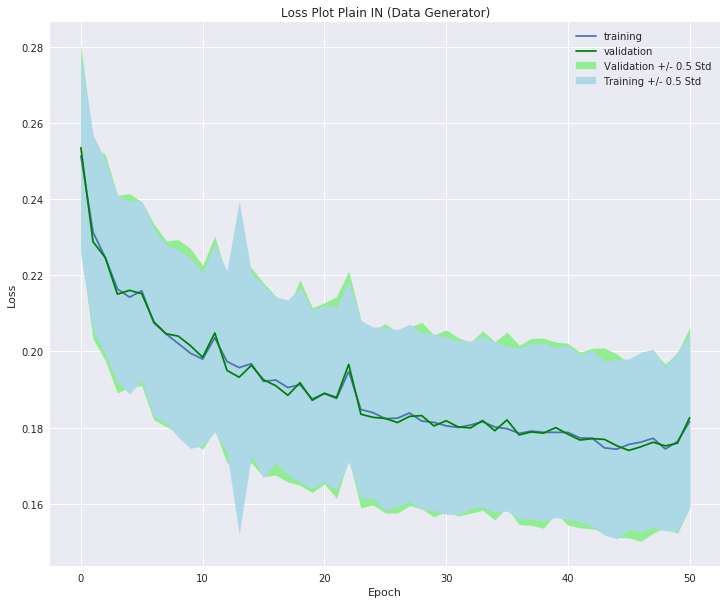

In [9]:
# Generate Loss Plot
loss_vals_training = loss_vals_training[:(final_epoch)] 
loss_vals_validation = loss_vals_validation[:(final_epoch)] 
loss_validation_std = loss_validation_std[:(final_epoch)] 
loss_training_std = loss_training_std[:(final_epoch)] 
epochs = np.array(range(len(loss_vals_training)))
fig = plt.figure(figsize = (12,10))
ax1 = fig.add_subplot(111)
ax1.plot(epochs, loss_vals_training, label='training')
ax1.plot(epochs, loss_vals_validation, label='validation', color = 'green')
ax1.fill_between(epochs, loss_vals_validation - loss_validation_std/2, loss_vals_validation + loss_validation_std/2, color = 'lightgreen', label = 'Validation +/- 0.5 Std')
ax1.fill_between(epochs, loss_vals_training - loss_training_std/2, loss_vals_training + loss_training_std/2, color = 'lightblue', label = 'Training +/- 0.5 Std')
plt.legend(loc='upper right')
plt.title('Loss Plot Plain IN (Data Generator)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('Loss_SV_tracks_data_generator')
plt.show()

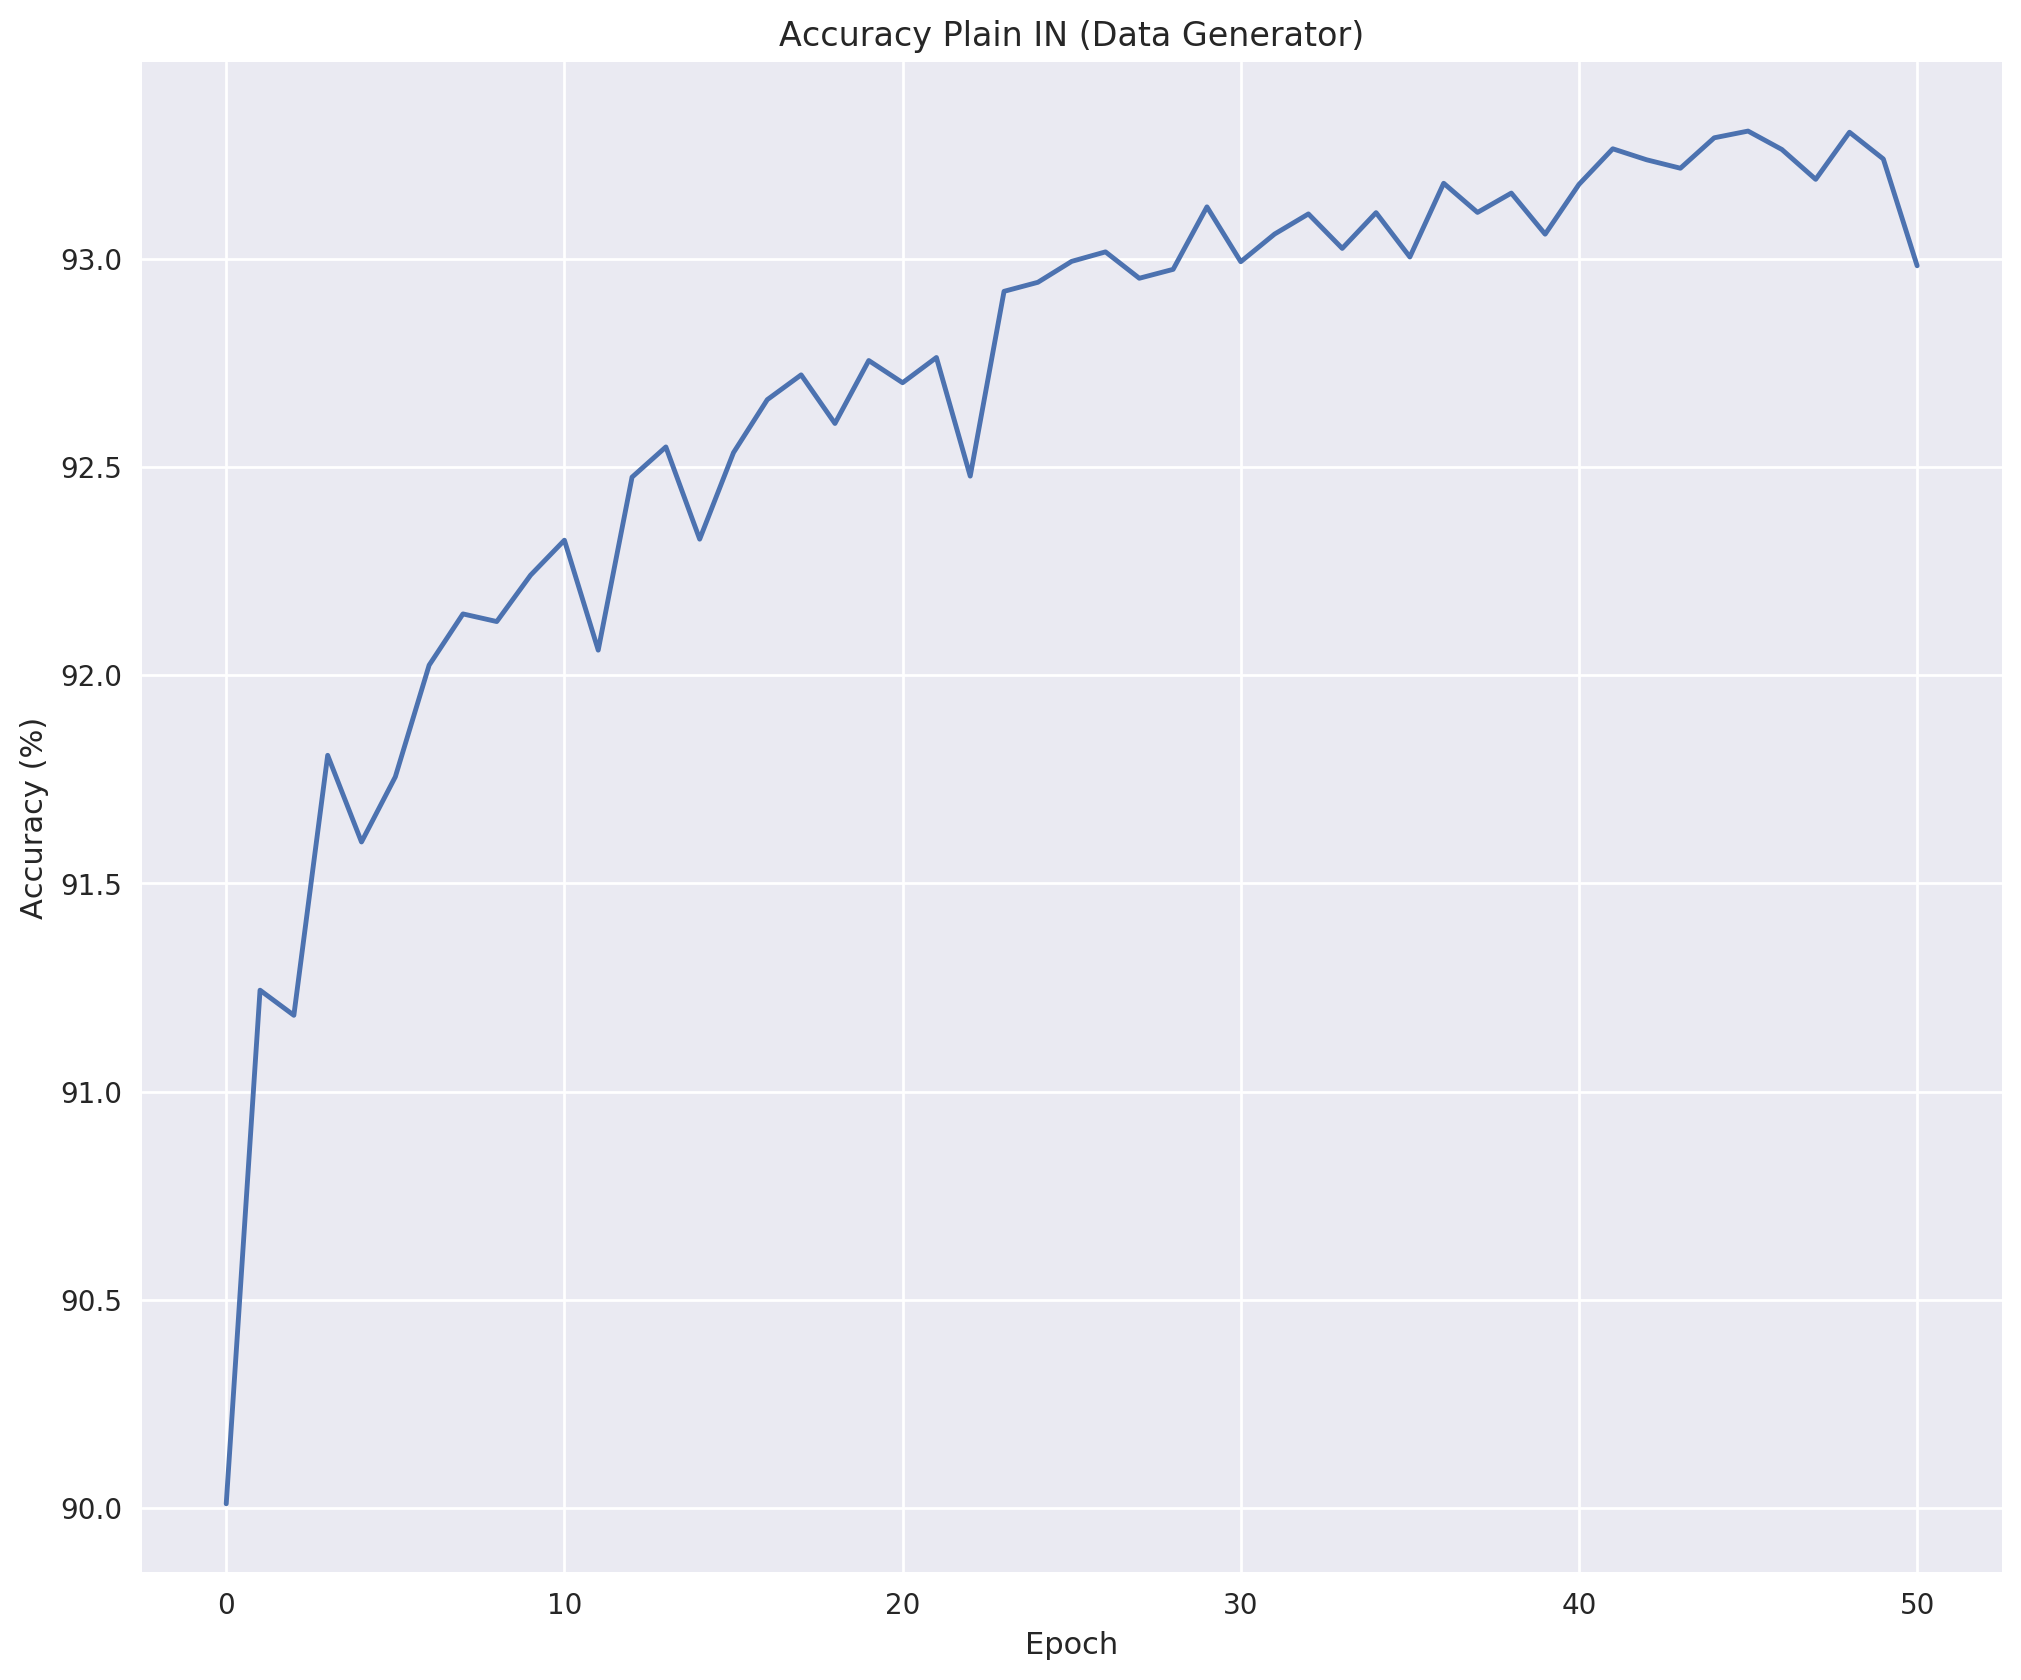

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 10), dpi = 200)
plt.plot(acc_vals[:final_epoch])
sns.set()
plt.title('Accuracy Plain IN (Data Generator)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.savefig("Accuracy_SV_tracks_dataGenerator")

plt.show()

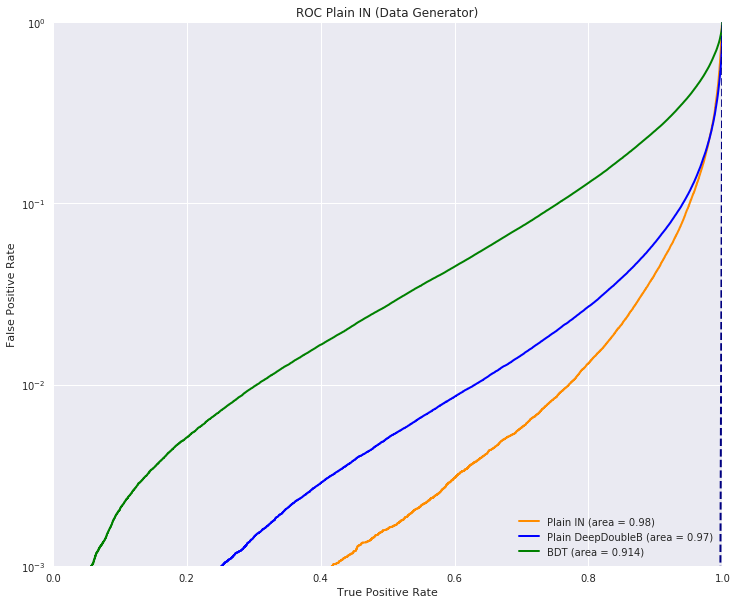

In [10]:
# Generate ROC Plot
from sklearn.metrics import roc_curve, roc_auc_score
softmax = torch.nn.Softmax(dim=1)
gnn.eval()
prediction = np.array([])
out = np.array([])
for j in range(0, testv.size()[0], batch_size):
    out_test = softmax(gnn(testv[j:j + batch_size].cuda(), testv_sv[j:j + batch_size].cuda()))
    out_test = out_test.cpu().data.numpy()
   
    for i in range(len(out_test)):
        if (out_test[i][0] > out_test[i][1]): 
            prediction = np.append(prediction, out_test[i][0])
            out = np.append(out, 0)
        else: 
            prediction = np.append(prediction, out_test[i][1])
            out = np.append(out, 1)

for i in range(prediction.size): 
    if out[i] == 0: 
        prediction[i] = 1.0 - prediction[i]
        
fpr, tpr, thresholds = roc_curve(targetv_test.cpu().data.numpy(), prediction)
auc = roc_auc_score(targetv_test.cpu().data.numpy(), prediction)

fpr_DeepDoubleB = np.load('fpr_DeepDoubleB.npy')
tpr_DeepDoubleB = np.load('tpr_DeepDoubleB.npy')
dfpr_BDT = np.load('dfpr_BDT.npy')
dtpr_BDT = np.load('dtpr_BDT.npy')

plt.figure(figsize=(12,10))
lw = 2
plt.semilogy(tpr, fpr, color='darkorange',
         lw=lw, label='Plain IN (area = %0.2f)' % auc)
plt.plot(tpr_DeepDoubleB, fpr_DeepDoubleB, color='blue',
         lw=lw, label='Plain DeepDoubleB (area = 0.97)')
plt.plot(dtpr_BDT, dfpr_BDT, color='green',
         lw=lw, label='BDT (area = 0.914)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([10**-3, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Plain IN (Data Generator)')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_data_generator')
plt.show()

In [ ]:
test_full = torch.FloatTensor(np.concatenate(np.array([test])))
test_sv_full = torch.FloatTensor(np.concatenate(np.array([test_sv])))
prediction_test = np.array([])
gnn_out = np.array([])
for j in range(0, test_full.size()[0], batch_size):
    print(j)
    out_test = softmax(gnn(test_full[j:j + batch_size].cuda(), test_sv_full[j:j + batch_size].cuda()))
    out_test = out_test.cpu().data.numpy()
    for i in range(len(out_test)):
        if (out_test[i][0] > out_test[i][1]): 
            prediction_test = np.append(prediction_test, out_test[i][0])
            gnn_out = np.append(gnn_out, 0)
        else: 
            prediction_test = np.append(prediction_test, out_test[i][1])
            gnn_out = np.append(gnn_out, 1)

for i in range(prediction_test.size): 
    if gnn_out[i] == 0: 
        prediction_test[i] = 1.0 - prediction_test[i]
    
#np.save('out', out)
#np.save('prediction', prediction_test)

In [ ]:
train_full = torch.FloatTensor(np.concatenate(np.array([train])))
train_sv_full = torch.FloatTensor(np.concatenate(np.array([train_sv])))
prediction_train = np.array([])
gnn_out = np.array([])
for j in range(0, test_full.size()[0], batch_size * 10):
    print(j)
    out_test = softmax(gnn(test_full[j:j + batch_size * 10].cuda(), test_sv_full[j:j + batch_size * 10].cuda()))
    out_test = out_test.cpu().data.numpy()
    for i in range(len(out_test)):
        if (out_test[i][0] > out_test[i][1]): 
            prediction_test = np.append(prediction_test, out_test[i][0])
            gnn_out = np.append(gnn_out, 0)
        else: 
            prediction_test = np.append(prediction_test, out_test[i][1])
            gnn_out = np.append(gnn_out, 1)

for i in range(prediction_test.size): 
    if gnn_out[i] == 0: 
        prediction_test[i] = 1.0 - prediction_test[i]
    

In [ ]:
np.save('out', gnn_out)
np.save('prediction', prediction_test)
np.save('tpr', tpr)
np.save('fpr', fpr)
np.save('thresholds', thresholds)

In [ ]:
torch.cuda.empty_cache()